In [ ]:
import os
import mne
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt

In [ ]:
main = "Emotiv"

output_base_folder = "process"
os.makedirs(output_base_folder, exist_ok=True)

# функція для обробки файлів
def process_and_save(file_path, output_path):
    try:
        # завантаження .fif файлу
        raw = mne.io.read_raw_fif(file_path, preload=True)

        # фільтрація сигналів
        raw_filtered = raw.copy().filter(l_freq=1.0, h_freq=40.0)

        # видалення артефактів за допомогою ICA
        ica = mne.preprocessing.ICA(n_components=14, random_state=97)
        ica.fit(raw_filtered)

        # перевірка наявності EOG каналів та виявлення артефактів EOG
        eog_channels = [ch for ch in raw.ch_names if 'EOG' in ch]
        if eog_channels:
            eog_indices, _ = ica.find_bads_eog(raw_filtered, ch_name=eog_channels)
            ica.exclude = eog_indices

        # перевірка наявності ECG каналів та виявлення артефактів ECG
        ecg_channels = [ch for ch in raw.ch_names if 'ECG' in ch]
        if ecg_channels:
            ecg_indices, _ = ica.find_bads_ecg(raw_filtered, ch_name=ecg_channels, method='correlation')
            ica.exclude.extend(ecg_indices)

        # застосування ICA для видалення артефактів
        raw_clean = ica.apply(raw_filtered)

        # розрахунок спектральної щільності потужності (PSD)
        psd = raw_clean.compute_psd(method='welch', fmin=1, fmax=40, n_fft=2048)
        psds, freqs = psd.get_data(return_freqs=True)

        # вибір частотних діапазонів
        # delta_power = psds[:, (freqs >= 1) & (freqs < 4)].mean(axis=1)
        theta_power = psds[:, (freqs >= 4) & (freqs < 8)].mean(axis=1)
        alpha_power = psds[:, (freqs >= 8) & (freqs < 13)].mean(axis=1)
        beta_power = psds[:, (freqs >= 13) & (freqs < 30)].mean(axis=1)
        gamma_power = psds[:, (freqs >= 30) & (freqs < 40)].mean(axis=1)

        # статистичний аналіз
        t_stat, p_val = ttest_rel(raw.get_data(), raw_clean.get_data())
        print(f"Статистичний тест для {file_path}: t-значення = {t_stat.mean()}, p-значення = {p_val.mean()}")

        # збереження обробленого файлу
        raw_clean.save(output_path, overwrite=True)
        print(f"Файл успішно оброблений та збережений: {output_path}")

    except Exception as e:
        print(f"Помилка при обробці файлу {file_path}: {e}")


In [ ]:
# прохід по всіх підпапках
for root, dirs, files in os.walk(main):
    for file in files:
        if file.endswith(".fif"):
            input_file_path = os.path.join(root, file)  # шлях до вихідного файлу
            relative_path = os.path.relpath(root, main)  # відносний шлях від базової папки
            output_folder = os.path.join(output_base_folder, relative_path)  # відповідна вихідна папка

            # створення вихідної папки, якщо її не існує
            os.makedirs(output_folder, exist_ok=True)

            # вихідний шлях для збереження
            output_file_path = os.path.join(output_folder, file)

            # обробка та збереження
            process_and_save(input_file_path, output_file_path)

Opening raw data file Emotiv\SUB01\SUB01VID01_eeg.fif...
    Range : 0 ... 15616 =      0.000 ...    61.000 secs
Ready.
Reading 0 ... 15616  =      0.000 ...    61.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting b

C:\Users\annbu\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Selecting by number: 14 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Effective window size : 8.000 (s)
Статистичний тест для Emotiv\SUB01\SUB01VID21_eeg.fif: t-значення = 244.8105297144952, p-значення = 5.613784040728013e-25
Writing C:\Users\annbu\affect\process\SUB01\SUB01VID21_eeg.fif
Closing C:\Users\annbu\affect\process\SUB01\SUB01VID21_eeg.fif
[done]
Файл успішно оброблений та збережений: process\SUB01\SUB01VID21_eeg.fif
Opening raw data file Emotiv\SUB01\SUB01VID23_eeg.fif...
    Range : 0 ... 30976 =      0.000 ...   121.000 secs
Ready.
Reading 0 ... 30976  =      0.000 ...   121.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming wind

C:\Users\annbu\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA took 5.1s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Effective window size : 8.000 (s)
Статистичний тест для Emotiv\SUB02\SUB02VID04_eeg.fif: t-значення = 292.6562383978213, p-значення = 5.508794392187607e-26
Writing C:\Users\annbu\affect\process\SUB02\SUB02VID04_eeg.fif
Closing C:\Users\annbu\affect\process\SUB02\SUB02VID04_eeg.fif
[done]
Файл успішно оброблений та збережений: process\SUB02\SUB02VID04_eeg.fif
Opening raw data file Emotiv\SUB02\SUB02VID05_eeg.fif...
    Range : 0 ... 46336 =      0.000 ...   181.000 secs
Ready.
Reading 0 ... 46336  =      0.000 ...   181.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 

C:\Users\annbu\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Selecting by number: 14 components
Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Effective window size : 8.000 (s)
Статистичний тест для Emotiv\SUB02\SUB02VID05_eeg.fif: t-значення = 292.36438002337405, p-значення = 4.837873029733135e-26
Writing C:\Users\annbu\affect\process\SUB02\SUB02VID05_eeg.fif
Closing C:\Users\annbu\affect\process\SUB02\SUB02VID05_eeg.fif
[done]
Файл успішно оброблений та збережений: process\SUB02\SUB02VID05_eeg.fif
Opening raw data file Emotiv\SUB02\SUB02VID07_eeg.fif...
    Range : 0 ... 30976 =      0.000 ...   121.000 secs
Ready.
Reading 0 ... 30976  =      0.000 ...   121.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming win

C:\Users\annbu\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Selecting by number: 14 components
Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Effective window size : 8.000 (s)
Статистичний тест для Emotiv\SUB03\SUB03VID19_eeg.fif: t-значення = 295.6986269206826, p-значення = 1.3234954049572002e-25
Writing C:\Users\annbu\affect\process\SUB03\SUB03VID19_eeg.fif
Closing C:\Users\annbu\affect\process\SUB03\SUB03VID19_eeg.fif
[done]
Файл успішно оброблений та збережений: process\SUB03\SUB03VID19_eeg.fif
Opening raw data file Emotiv\SUB03\SUB03VID20_eeg.fif...
    Range : 0 ... 16640 =      0.000 ...    65.000 secs
Ready.
Reading 0 ... 16640  =      0.000 ...    65.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming win

C:\Users\annbu\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Selecting by number: 14 components
Fitting ICA took 0.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Effective window size : 8.000 (s)
Статистичний тест для Emotiv\SUB04\SUB04VID21_eeg.fif: t-значення = 250.52670292637654, p-значення = 4.215837121635782e-25
Writing C:\Users\annbu\affect\process\SUB04\SUB04VID21_eeg.fif
Closing C:\Users\annbu\affect\process\SUB04\SUB04VID21_eeg.fif
[done]
Файл успішно оброблений та збережений: process\SUB04\SUB04VID21_eeg.fif
Opening raw data file Emotiv\SUB04\SUB04VID23_eeg.fif...
    Range : 0 ... 30976 =      0.000 ...   121.000 secs
Ready.
Reading 0 ... 30976  =      0.000 ...   121.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming win

C:\Users\annbu\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


    Range : 0 ... 30976 =      0.000 ...   121.000 secs
Ready.
Reading 0 ... 30976  =      0.000 ...   121.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Effective window size : 8.000

C:\Users\annbu\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Effective window size : 8.000 (s)
Статистичний тест для Emotiv\SUB05\SUB05VID08_eeg.fif: t-значення = 255.24119160590988, p-значення = 8.10651761415337e-16
Writing C:\Users\annbu\affect\process\SUB05\SUB05VID08_eeg.fif
Closing C:\Users\annbu\affect\process\SUB05\SUB05VID08_eeg.fif
[done]
Файл успішно оброблений та збережений: process\SUB05\SUB05VID08_eeg.fif
Opening raw data file Emotiv\SUB05\SUB05VID09_eeg.fif...
    Range : 0 ... 30976 =      0.000 ...   121.000 secs
Ready.
Reading 0 ... 30976  =      0.000 ...   121.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 

C:\Users\annbu\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 0.7s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Effective window size : 8.000 (s)
Статистичний тест для Emotiv\SUB07\SUB07VID05_eeg.fif: t-значення = 229.28867392982391, p-значення = 4.250448760783509e-23
Writing C:\Users\annbu\affect\process\SUB07\SUB07VID05_eeg.fif
Closing C:\Users\annbu\affect\process\SUB07\SUB07VID05_eeg.fif
[done]
Файл успішно оброблений та збережений: process\SUB07\SUB07VID05_eeg.fif
Opening raw data file Emotiv\SUB07\SUB07VID07_eeg.fif...
    Range : 0 ... 30976 =      0.000 ...   121.000 secs
Ready.
Reading 0 ... 30976  =      0.000 ...   121.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-ca

C:\Users\annbu\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Selecting by number: 14 components
Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Effective window size : 8.000 (s)
Статистичний тест для Emotiv\SUB07\SUB07VID23_eeg.fif: t-значення = 247.03086772116148, p-значення = 9.713431634784201e-25
Writing C:\Users\annbu\affect\process\SUB07\SUB07VID23_eeg.fif
Closing C:\Users\annbu\affect\process\SUB07\SUB07VID23_eeg.fif
[done]
Файл успішно оброблений та збережений: process\SUB07\SUB07VID23_eeg.fif
Opening raw data file Emotiv\SUB07\SUB07VID24_eeg.fif...
    Range : 0 ... 30976 =      0.000 ...   121.000 secs
Ready.
Reading 0 ... 30976  =      0.000 ...   121.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming win

C:\Users\annbu\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Selecting by number: 14 components
Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Effective window size : 8.000 (s)
Статистичний тест для Emotiv\SUB10\SUB10VID20_eeg.fif: t-значення = 230.32762484980196, p-значення = 1.7517949991742523e-23
Writing C:\Users\annbu\affect\process\SUB10\SUB10VID20_eeg.fif
Closing C:\Users\annbu\affect\process\SUB10\SUB10VID20_eeg.fif
[done]
Файл успішно оброблений та збережений: process\SUB10\SUB10VID20_eeg.fif
Opening raw data file Emotiv\SUB10\SUB10VID21_eeg.fif...
    Range : 0 ... 30976 =      0.000 ...   121.000 secs
Ready.
Reading 0 ... 30976  =      0.000 ...   121.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming wi

C:\Users\annbu\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Selecting by number: 14 components
Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Effective window size : 8.000 (s)
Статистичний тест для Emotiv\SUB13\SUB13VID21_eeg.fif: t-значення = 258.4810818790893, p-значення = 3.1167893437709134e-20
Writing C:\Users\annbu\affect\process\SUB13\SUB13VID21_eeg.fif
Closing C:\Users\annbu\affect\process\SUB13\SUB13VID21_eeg.fif
[done]
Файл успішно оброблений та збережений: process\SUB13\SUB13VID21_eeg.fif
Opening raw data file Emotiv\SUB13\SUB13VID23_eeg.fif...
    Range : 0 ... 30976 =      0.000 ...   121.000 secs
Ready.
Reading 0 ... 30976  =      0.000 ...   121.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming win

C:\Users\annbu\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Effective window size : 8.000 (s)
Статистичний тест для Emotiv\SUB13\SUB13VID24_eeg.fif: t-значення = 254.08860883961603, p-значення = 1.0130495857356039e-22
Writing C:\Users\annbu\affect\pro

C:\Users\annbu\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Selecting by number: 14 components
Fitting ICA took 9.1s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Effective window size : 8.000 (s)
Статистичний тест для Emotiv\SUB14\SUB14VID08_eeg.fif: t-значення = 247.40234236372515, p-значення = 3.3001668272595814e-25
Writing C:\Users\annbu\affect\process\SUB14\SUB14VID08_eeg.fif
Closing C:\Users\annbu\affect\process\SUB14\SUB14VID08_eeg.fif
[done]
Файл успішно оброблений та збережений: process\SUB14\SUB14VID08_eeg.fif
Opening raw data file Emotiv\SUB14\SUB14VID09_eeg.fif...
    Range : 0 ... 30976 =      0.000 ...   121.000 secs
Ready.
Reading 0 ... 30976  =      0.000 ...   121.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming wi

C:\Users\annbu\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Effective window size : 8.000 (s)
Статистичний тест для Emotiv\SUB14\SUB14VID09_eeg.fif: t-значення = 223.00350335576408, p-значення = 9.415977275264206e-24
Writing C:\Users\annbu\affect\process\SUB14\SUB14VID09_eeg.fif
Closing C:\Users\annbu\affect\process\SUB14\SUB14VID09_eeg.fif
[done]
Файл успішно оброблений та збережений: process\SUB14\SUB14VID09_eeg.fif
Opening raw data file Emotiv\SUB14\SUB14VID10_eeg.fif...
    Range : 0 ... 30976 =      0.000 ...   121.000 secs
Ready.
Reading 0 ... 30976  =      0.000 ...   121.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-ca

C:\Users\annbu\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA took 10.6s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Effective window size : 8.000 (s)
Статистичний тест для Emotiv\SUB14\SUB14VID24_eeg.fif: t-значення = 238.87651555864304, p-значення = 5.318973387237951e-25
Writing C:\Users\annbu\affect\process\SUB14\SUB14VID24_eeg.fif
Closing C:\Users\annbu\affect\process\SUB14\SUB14VID24_eeg.fif
[done]
Файл успішно оброблений та збережений: process\SUB14\SUB14VID24_eeg.fif
Opening raw data file Emotiv\SUB14\SUB14VID25_eeg.fif...
    Range : 0 ... 30976 =      0.000 ...   121.000 secs


C:\Users\annbu\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Ready.
Reading 0 ... 30976  =      0.000 ...   121.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Effective window size : 8.000 (s)
Статистичний тест для Emotiv\SUB14\SUB14VID25_eeg.f

C:\Users\annbu\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Effective window size : 8.000 (s)
Статистичний тест для Emotiv\SUB16\SUB16VID05_eeg.fif: t-значення = 312.57015931062824, p-значення = 5.204416345553152e-20
Writing C:\Users\annbu\affect\process\SUB16\SUB16VID05_eeg.fif
Closing C:\Users\annbu\affect\process\SUB16\SUB16VID05_eeg.fif
[done]
Файл успішно оброблений та збережений: process\SUB16\SUB16VID05_eeg.fif
Opening raw data file Emotiv\SUB16\SUB16VID07_eeg.fif...
    Range : 0 ... 30976 =      0.000 ...   121.000 secs
Ready.
Reading 0 ... 30976  =      0.000 ...   121.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-ca

C:\Users\annbu\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Selecting by number: 14 components
Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Effective window size : 8.000 (s)
Статистичний тест для Emotiv\SUB19\SUB19VID24_eeg.fif: t-значення = 200.06060205410694, p-значення = 2.0293365031714065e-14
Writing C:\Users\annbu\affect\process\SUB19\SUB19VID24_eeg.fif
Closing C:\Users\annbu\affect\process\SUB19\SUB19VID24_eeg.fif
[done]
Файл успішно оброблений та збережений: process\SUB19\SUB19VID24_eeg.fif
Opening raw data file Emotiv\SUB19\SUB19VID25_eeg.fif...
    Range : 0 ... 30976 =      0.000 ...   121.000 secs
Ready.
Reading 0 ... 30976  =      0.000 ...   121.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming wi

C:\Users\annbu\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 0.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Effective window size : 8.000 (s)
Статистичний тест для Emotiv\SUB25\SUB25VID19_eeg.fif: t-значення = 183.15718799065195, p-значення = 5.878075595641137e-15
Writing C:\Users\annbu\affect\proc

C:\Users\annbu\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Effective window size : 8.000 (s)
Статистичний тест для Emotiv\SUB28\SUB28VID02_eeg.fif: t-значення = 284.01117844480905, p-значення = 8.235191906094931e-25
Writing C:\Users\annbu\affect\process\SUB28\SUB28VID02_eeg.fif
Closing C:\Users\annbu\affect\process\SUB28\SUB28VID02_eeg.fif
[done]
Файл успішно оброблений та збережений: process\SUB28\SUB28VID02_eeg.fif
Opening raw data file Emotiv\SUB28\SUB28VID03_eeg.fif...
    Range : 0 ... 30976 =      0.000 ...   121.000 secs
Ready.
Reading 0 ... 30976  =      0.000 ...   121.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-ca

C:\Users\annbu\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Selecting by number: 14 components
Fitting ICA took 0.4s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Effective window size : 8.000 (s)
Статистичний тест для Emotiv\SUB28\SUB28VID05_eeg.fif: t-значення = 280.4349624314737, p-значення = 7.787303969776077e-26
Writing C:\Users\annbu\affect\process\SUB28\SUB28VID05_eeg.fif
Closing C:\Users\annbu\affect\process\SUB28\SUB28VID05_eeg.fif
[done]
Файл успішно оброблений та збережений: process\SUB28\SUB28VID05_eeg.fif
Opening raw data file Emotiv\SUB28\SUB28VID07_eeg.fif...
    Range : 0 ... 30976 =      0.000 ...   121.000 secs
Ready.
Reading 0 ... 30976  =      0.000 ...   121.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming wind

C:\Users\annbu\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Selecting by number: 14 components
Fitting ICA took 0.3s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Effective window size : 8.000 (s)
Статистичний тест для Emotiv\SUB28\SUB28VID21_eeg.fif: t-значення = 307.4639502460179, p-значення = 1.461859963672573e-25
Writing C:\Users\annbu\affect\process\SUB28\SUB28VID21_eeg.fif
Closing C:\Users\annbu\affect\process\SUB28\SUB28VID21_eeg.fif
[done]
Файл успішно оброблений та збережений: process\SUB28\SUB28VID21_eeg.fif
Opening raw data file Emotiv\SUB28\SUB28VID23_eeg.fif...
    Range : 0 ... 30976 =      0.000 ...   121.000 secs
Ready.
Reading 0 ... 30976  =      0.000 ...   121.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming wind

C:\Users\annbu\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Fitting ICA took 10.0s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Effective window size : 8.000 (s)
Статистичний тест для Emotiv\SUB29\SUB29VID19_eeg.fif: t-значення = 215.033870703336, p-значення = 2.715432501211379e-24
Writing C:\Users\annbu\affect\process\SUB29\SUB29VID19_eeg.fif
Closing C:\Users\annbu\affect\process\SUB29\SUB29VID19_eeg.fif
[done]
Файл успішно оброблений та збережений: process\SUB29\SUB29VID19_eeg.fif
Opening raw data file Emotiv\SUB29\SUB29VID20_eeg.fif...
    Range : 0 ... 16640 =      0.000 ...    65.000 secs
Ready.


C:\Users\annbu\AppData\Roaming\Python\Python312\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Reading 0 ... 16640  =      0.000 ...    65.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 14 PCA components
Effective window size : 8.000 (s)
Статистичний тест для Emotiv\SUB29\SUB29VID20_eeg.fif: t-з

In [ ]:
# не працює

# експорт даних у DataFrame
data, times = raw_data[:]
df = pd.DataFrame(data.T, columns=raw_data.ch_names)  # Транспонуємо дані для табличного вигляду
df['Time'] = times

# збереження у CSV
output_csv = os.path.join(output_folder, "processed_signal.csv")
df.to_csv(output_csv, index=False)
print(f"Оброблений сигнал збережено у файл {output_csv}")

Opening raw data file Emotiv/SUB01/SUB01VID05_eeg.fif...
    Range : 0 ... 46336 =      0.000 ...   181.000 secs
Ready.
Reading 0 ... 46336  =      0.000 ...   181.000 secs...
Opening raw data file processed/SUB01/SUB01VID05_eeg.fif...
    Range : 0 ... 46336 =      0.000 ...   181.000 secs
Ready.
Reading 0 ... 46336  =      0.000 ...   181.000 secs...
Статистичний тест: t-значення = 306.4036895814961, p-значення = 5.292134979312842e-23
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)


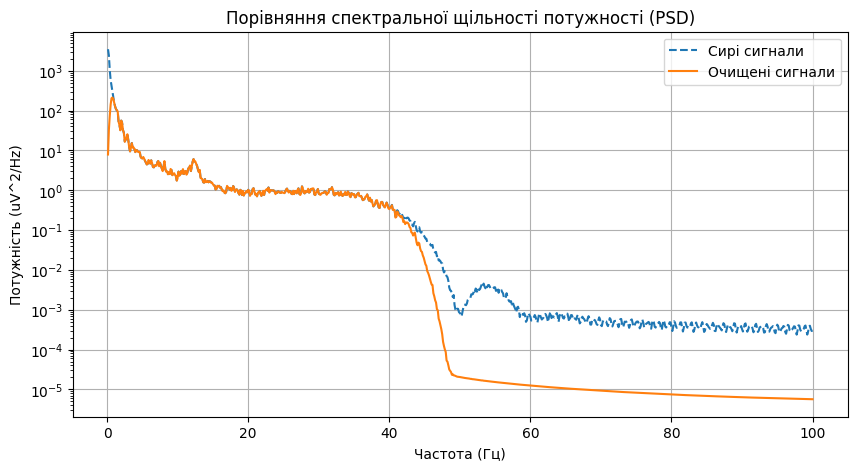

In [ ]:
raw_file_path = "Emotiv/SUB01/SUB01VID05_eeg.fif"
processed_file_path = "processed/SUB01/SUB01VID05_eeg.fif"
if not (os.path.exists(raw_file_path) and os.path.exists(processed_file_path)):
    print("Один або обидва файли не існують. Перевірте шляхи.")
    exit()

raw = mne.io.read_raw_fif(raw_file_path, preload=True)
processed = mne.io.read_raw_fif(processed_file_path, preload=True)

t_stat, p_val = ttest_rel(raw.get_data(), processed.get_data())
print(f"Статистичний тест: t-значення = {t_stat.mean()}, p-значення = {p_val.mean()}")

# розрахунок спектральної щільності потужності (PSD) для сирих і очищених сигналів
psd_raw = raw.compute_psd(method='welch', fmin=0.1, fmax=100, n_fft=2048)
psds_raw, freqs_raw = psd_raw.get_data(return_freqs=True)
psd_processed = processed.compute_psd(method='welch', fmin=0.1, fmax=100, n_fft=2048)
psds_processed, freqs_processed = psd_processed.get_data(return_freqs=True)

# візуалізація порівняння PSD для сирих та оброблених сигналів
plt.figure(figsize=(10, 5))
plt.semilogy(freqs_raw, psds_raw.mean(axis=0), label='Сирі сигнали', linestyle='--')
plt.semilogy(freqs_processed, psds_processed.mean(axis=0), label='Очищені сигнали', linestyle='-')
plt.xlabel('Частота (Гц)')
plt.ylabel('Потужність (uV^2/Hz)')
plt.legend()
plt.title('Порівняння спектральної щільності потужності (PSD)')
plt.grid(True)
plt.show()